#### Copyright (c) 2025, Mohammadjavad Vakili
#### Disclaimer: The content of this notebook is for educational purposes only and comes with no warranty. No financial advice is provided.

# Example usage of PenFolioOp with US Benchmarks


We have collected the following return data for various US asset classes:

| Asset Class Name                        | Benchmark                                             | Source                                       |
|------------------------------------------|-------------------------------------------------------|-----------------------------------------------------|
| Cash                                    | iShares 0-3 Month Treasury Bond ETF                   | iShares          |
| Government Bond                         | iShares 20 Year Treasury Bond ETF                     | iShares           |
| High Yield Corporate Bond                | iShares iBoxx High Yield Corporate Bond ETF         | iShares           |
| Investment Grade Corporate Bond          | iShares iBoxx Investment Grade Corporate Bond ETF   | iShares           |
| Emerging Market Debt Local Currency      | iShares JP Morgan EM Local Currency Bond ETF          | iShares           |
| Emerging Market Debt Hard Currency       | iShares JP Morgan USD Emerging Markets Bond ETF       | iShares           |
| Equity                                  | iShares MSCI World ETF                               | iShares           |
| Real Estate                             | iShares US Real Estate ETF                       | iShares           |
| liabilities                            |    ICE BofA AAA US Corporate Index Total Return Index                      | Fred          |

In [ ]:
# Copyright (c) 2025, Mohammadjavad Vakili
# Disclaimer: The content of this notebook is for educational purposes only and comes with no warranty.
# No financial advice is provided.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

from penfolioop.optimizers import (
    efficient_frontier,
    max_surplus_return_optimizer,
    max_surplus_sharpe_ratio_optimizer,
    min_surplus_variance_optimizer,
    surplus_mean_variance_optimizer,
)
from penfolioop.portfolio import Portfolio

In [2]:
benchmark_returns = pd.read_csv("resources/benchmarks.csv", index_col=0, parse_dates=True, dtype=float)["2016":]

First, we estimate the `expected_returns`, and `covariance_matrix`with the historical returns data. We also estimate the correlation matrix so that we can visualize the correlations between the returns of different asset classes.

In [3]:
expected_returns = benchmark_returns.mean()
covariance_matrix = benchmark_returns.cov()
correlation_matrix = benchmark_returns.corr()
names = benchmark_returns.columns.to_list()

Let's visualize the correlation between returns of different asset classes.

Text(0.5, 1.0, 'Correlation between Asset Class Returns')

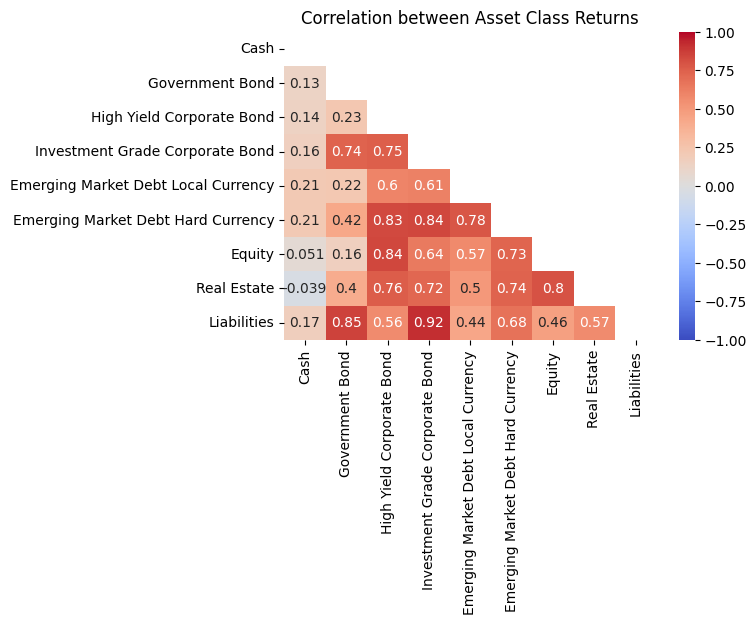

In [4]:
correlation = benchmark_returns.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap="coolwarm", vmin=-1, vmax=1, mask=mask, ax=ax)
ax.set_title("Correlation between Asset Class Returns")

In [ ]:
pio.renderers.default = "notebook_connected"
fig = px.bar(
    expected_returns.sort_values(ascending=False),
    title="Expected Returns by Asset Class",
    labels={"value": "Expected Return", "index": "Asset Class"},
    text_auto=".2%",
    color=expected_returns.index,
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_layout(
    showlegend=False,
    title_x=0.5,
    height=350,
    margin=dict(l=30, r=30, t=50, b=30),
    xaxis_tickangle=-30,
    font=dict(size=12)
)
fig.update_traces(marker_line_width=1.5, marker_line_color="black")
fig.show()

In [5]:
pio.renderers.default = "notebook_connected"
fig = px.bar(
    benchmark_returns.std().sort_values(ascending=False),
    title="Expected Volatility by Asset Class",
    labels={"value": "Expected Volatility", "index": "Asset Class"},
    text_auto=".2%",
    color=names,
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_layout(
    showlegend=False,
    title_x=0.5,
    height=350,
    margin=dict(l=30, r=30, t=50, b=30),
    xaxis_tickangle=-30,
    font=dict(size=12)
)
fig.update_traces(marker_line_width=1.5, marker_line_color="black")
fig.show()

Now, we define our `portfolio` object

In [6]:
portfolio = Portfolio(
    names=names,
    expected_returns=expected_returns.values,
    covariance_matrix=covariance_matrix.values,
)

We define the following constraints on our asset classes:

- `Cash` weight must be below 0.1.
- The combined weight of `Emerging Market Debt Local Currency` and `Emerging Market Debt Hard Currency` must be less than that of `Equity`.
- The combined weights of the return seeking (`Emerging Market Debt Local Currency`, `Emerging Market Debt Hard Currency`, `Equity`, `High Yield Corporate Bond`) assets must be at least 0.3.
- The weight of `Real Estate` must be greater than 0.1.
- The weight of `Investment Grade Corporate Bond` must be at least 0.3.


In [7]:
constraints = [
    {"left_indices": ["Cash"],
    "operator": "<=",
    "right_value": 0.1},

    {"left_indices": ["Emerging Market Debt Local Currency", "Emerging Market Debt Hard Currency"],
     "operator": "<=",
     "right_indices": ["Equity"]},

    {"left_indices": ["Emerging Market Debt Local Currency", "Emerging Market Debt Hard Currency", "Equity", "High Yield Corporate Bond"],
     "operator": ">=",
     "right_value": 0.3},

    {"left_indices": ["Real Estate"],
     "operator": "<=",
     "right_value": 0.1},

    {"left_indices": ["Investment Grade Corporate Bond"],
     "operator": ">=",
     "right_value": 0.3},
]


Let's estimate the asset class weights using our defined constraints and the following optimizers:

- `min_surplus_variance_optimizer`,
- `max_surplus_return_optimizer`,
- `max_surplus_sharpe_ratio_optimizer`,
- `efficient_frontier`

In [ ]:
min_variance_weights = min_surplus_variance_optimizer(portfolio, asset_constraints=constraints)
min_variance_return = portfolio.surplus_return(min_variance_weights)
min_variance_vol = portfolio.surplus_variance(min_variance_weights)**.5


max_return_weights = max_surplus_return_optimizer(portfolio, asset_constraints=constraints)
max_return = portfolio.surplus_return(max_return_weights)
max_return_vol = portfolio.surplus_variance(max_return_weights)**.5

max_sharpe_weights = max_surplus_sharpe_ratio_optimizer(portfolio, asset_constraints=constraints)
max_sharpe_return = portfolio.surplus_return(max_sharpe_weights)
max_sharpe_vol = portfolio.surplus_variance(max_sharpe_weights)**.5


efficient_frontier_results = efficient_frontier(
    portfolio=portfolio,
    asset_constraints=constraints,
    surplus_return_range=(-0.005, 0.005),
)
ef_weights = efficient_frontier_results["weights"]
ef_returns = efficient_frontier_results["surplus_returns"]
ef_vols = efficient_frontier_results["surplus_variances"]**.5

In [9]:
optimizers = ["Min Surplus Variance Optimizer", "Max Surplus Return Optimizer", "Max Surplus Sharpe Ratio Optimizer"]
weights = np.vstack([min_variance_weights[:-1], max_return_weights[:-1], max_sharpe_weights[:-1]])

pio.renderers.default = "notebook_connected"
fig = go.Figure()
bar_width = 0.2
x = np.arange(len(names[:-1]))

for idx, (optimizer, color) in enumerate(zip(optimizers, px.colors.qualitative.Set1)):
    fig.add_trace(go.Bar(
        x=x + (idx - 1) * bar_width,
        y=weights[idx],
        name=optimizer,
        marker_color=color,
        width=bar_width,
        offset=0
    ))

fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=x,
        ticktext=names[:-1]
    ),
    barmode='group',
    title="Asset Class Weights by Optimizer",
    xaxis_title="Asset Class",
    yaxis_title="Weight",
    legend_title="Optimizer",
    font=dict(size=12),
    height=400
)
fig.show()

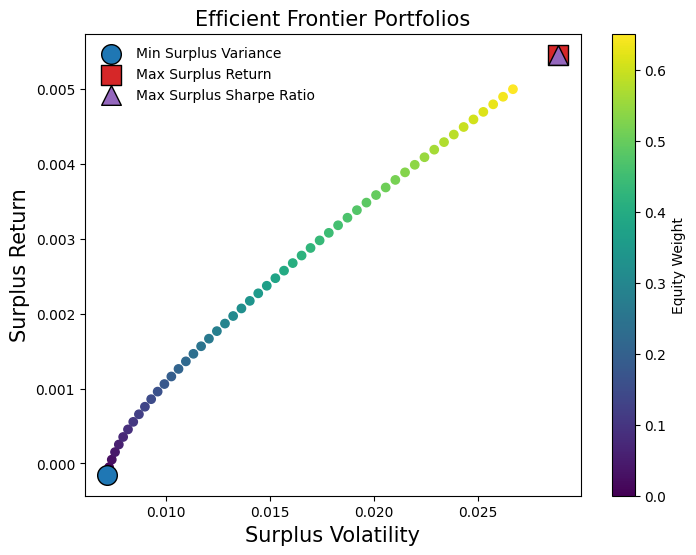

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(ef_vols, ef_returns, c=ef_weights[:, 6], cmap="viridis")
ax.scatter(min_variance_vol, min_variance_return, c='C0', s=200, edgecolors='black', marker='o', label='Min Surplus Variance')
ax.scatter(max_return_vol, max_return, c='C3', s=200, edgecolors='black', marker='s', label='Max Surplus Return')
ax.scatter(max_sharpe_vol, max_sharpe_return, c='C4', s=200, edgecolors='black', marker='^', label='Max Surplus Sharpe Ratio')

ax.set_xlabel("Surplus Volatility", fontsize=15)
ax.set_ylabel("Surplus Return", fontsize=15)
fig.colorbar(sc, label="Equity Weight")
ax.set_title("Efficient Frontier Portfolios", fontsize=15)
ax.legend(frameon=False)

In [11]:
pio.renderers.default = "notebook_connected"
fig = go.Figure()
for i, name in enumerate(portfolio.names[:-1]):  # Exclude 'Liabilities'
    fig.add_trace(go.Scatter(
        x=ef_returns,
        y=ef_weights[:, i],
        mode="lines",
        name=name,
        stackgroup="one",
    ))
fig.update_layout(
    title="Asset Weights Along the Efficient Frontier)",
    xaxis_title="Surplus Return",
    yaxis_title="Asset Weight",
    legend_title="Asset Class",
    hovermode="x unified",
)
fig.show()

## Mean-Variance Portfolio with different risk aversions

In [12]:
risk_aversion_values = [0, 10, 20, 50, 100]
mv_weights, mv_srs, mv_svols = {}, {}, {}

for risk_aversion in risk_aversion_values:
    mv_weights[risk_aversion] = surplus_mean_variance_optimizer(
        portfolio=portfolio,
        risk_aversion=risk_aversion,
        asset_constraints=constraints,
    )
    mv_srs[risk_aversion] = portfolio.surplus_return(weights=mv_weights[risk_aversion])
    mv_svols[risk_aversion] = portfolio.surplus_variance(weights=mv_weights[risk_aversion])**.5

In [13]:
pio.renderers.default = "notebook_connected"
fig = go.Figure()
bar_width = 0.2
x = np.arange(len(names[:-1]))

for idx, (risk_aversion, color) in enumerate(zip(risk_aversion_values, px.colors.qualitative.Set1)):
    fig.add_trace(go.Bar(
        x=x + (idx - 1) * bar_width,
        y=mv_weights[risk_aversion][:-1],
        name=f"Risk Aversion: {risk_aversion}",
        marker_color=color,
        width=bar_width,
        offset=0,
    ))

fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=x,
        ticktext=names[:-1]
    ),
    barmode="group",
    title="Asset Class Weights by Risk Aversion",
    xaxis_title="Asset Class",
    yaxis_title="Weight",
    legend_title="Risk aversion",
    font=dict(size=12),
    height=400
)
fig.show()

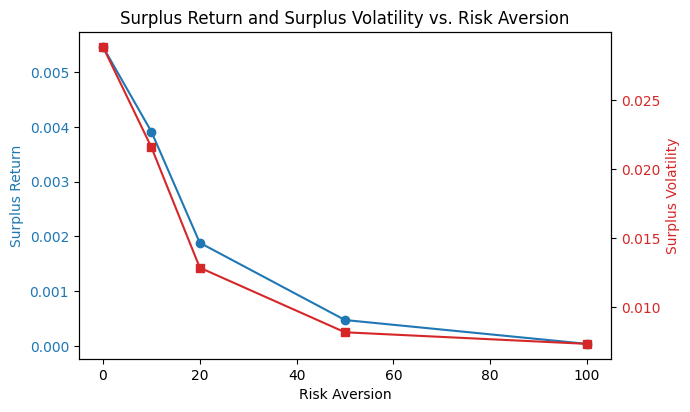

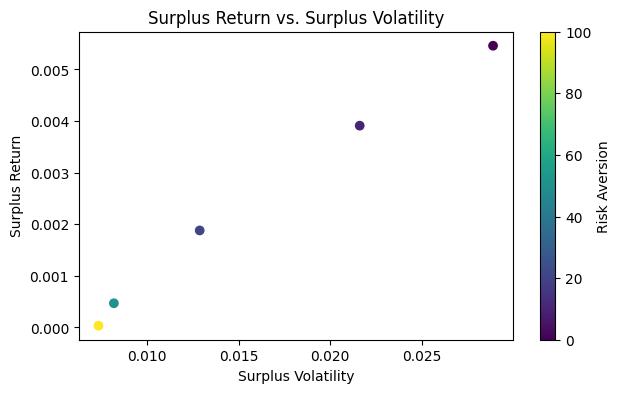

In [14]:
surplus_returns = [mv_srs[ra] for ra in risk_aversion_values]
surplus_vols = [mv_svols[ra] for ra in risk_aversion_values]

fig, ax1 = plt.subplots(figsize=(7, 4))

color1 = "tab:blue"
ax1.set_xlabel("Risk Aversion")
ax1.set_ylabel("Surplus Return", color=color1)
ax1.plot(risk_aversion_values, surplus_returns, marker="o", color=color1, label="Surplus Return")
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = "tab:red"
ax2.set_ylabel("Surplus Volatility", color=color2)
ax2.plot(risk_aversion_values, surplus_vols, marker="s", color=color2, label="Surplus Volatility")
ax2.tick_params(axis="y", labelcolor=color2)

fig.tight_layout()
plt.title("Surplus Return and Surplus Volatility vs. Risk Aversion")
plt.show()


fig, ax = plt.subplots(figsize=(7, 4))
plt.scatter(surplus_vols, surplus_returns, c=risk_aversion_values, cmap="viridis")
plt.xlabel("Surplus Volatility")
plt.ylabel("Surplus Return")
plt.title("Surplus Return vs. Surplus Volatility")
plt.colorbar(label="Risk Aversion")
plt.show()